## Authors: Abdul Jawad Mohammed, Dr. Amal Khalifa
## Dataset of Focus:
Potier et al. Drosophila Eye 72-sample RNA-seq expression Dataset

## Dataset Reference:
Delphine Potier, Kristofer Davie, Gert Hulselmans, Marina Naval Sanchez, Lotte Haagen, Vân Anh Huynh-Thu, Duygu Koldere, Arzu Celik, Pierre Geurts, Valerie Christiaens, Stein Aerts,
Mapping Gene Regulatory Networks in Drosophila Eye Development by Large-Scale Transcriptome Perturbations and Motif Inference,
Cell Reports,
Volume 9, Issue 6,
2014,
Pages 2290-2303,
ISSN 2211-1247,
https://doi.org/10.1016/j.celrep.2014.11.038.
(https://www.sciencedirect.com/science/article/pii/S2211124714010043)

## Acknowledgements:
Special Thanks to Dr. Peignier, who had provided support in regards to regulatory gene prediction. A part of this code was adapted and modified from the notebooks on his website: https://sergiopeignier.github.io

## I. SCENIC Analysis of Drosophila Dataset

In [ ]:
!pip install cytoolz
!pip install scanpy
!pip install pyscenic
!pip install annData

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=d54f6c2cbb683a7499bcac2316327db8cb5337586edaef4f37cd1333c2775453
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

## Importing Libraries

In [ ]:
%matplotlib inline

In [ ]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose
from collections import Counter

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
#from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set maximum number of jobs
sc.settings.njobs = 32

## Loading the Drosophila RNA-seq Dataset

In [ ]:
D_RNA = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/PotieretAl/GSE59059_all_network_experiments.countstable.txt",sep="\t")
# drop the genes that have no symbol (only 4)
c = Counter(D_RNA.Symbol)
{ k: c[k] for k in c if c[k]>1}
D_RNA = D_RNA.dropna()
# Set the index
D_RNA.index = D_RNA["Symbol"]
# Delete non-count columns
del D_RNA["ID"]
del D_RNA["Symbol"]
D_RNA = D_RNA.replace(0, np.nan)
D_RNA.head()

,Larval_brain_WT_RAL-208,Larval_brain_WT_cs,wing_imaginal_disc_WT_RAL-208_1-and-2_pooled,wing_imaginal_disc_WT_cs,eye-antennal_disc_RAL-80_GSM978988,eye-antennal_disc_cs_GSM978987,eye-antennal-imaginal-disc_GMR27H09-Gal4,eye-antennal-imaginal-disc_GMR-Gal4,eye-antennal-imaginal-disc_ato-Gal4,eye-antennal-imaginal-disc_sens-Gal4_x_UAS-GFP,...,eye-antennal-imaginal-disc_hs-Gal4_x_UAS-dfd,eye-antennal-imaginal-disc_ato-Gal4_x_UAS-repo,eye-antennal-imaginal-disc_ato-Gal4_x_EP-dip3,eye-antennal-imaginal-disc_GMR-gal4_x_UAS-Lim3,eye-antennal-imaginal-disc_m4-Gal4_x_UAS-mam,eye-antennal-imaginal-disc_m4-Gal4_x_EP-danr,eye-antennal-imaginal-disc_ato-Gal4_x_EP-dan,eye-antennal-imaginal-disc_m4-Gal4_x_EP-gbsN,eye-antennal-imaginal-disc_GMR-Gal4_x_UAS-lab,eye-antennal-imaginal-disc_GMR-Gal4_x_UAS-Su(H)
Symbol,,,,,,,,,,,,,,,,,,,,,
7SLRNA:CR32864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
a,1149.0,445.0,191.0,570.0,1588.0,1541.0,2082.0,1519.0,1597.0,1328.0,...,3115.0,1242.0,1066.0,1306.0,2625.0,2271.0,2174.0,1956.0,1324.0,1065.0
abd-A,689.0,571.0,1.0,13.0,138.0,138.0,11.0,9.0,NaN,95.0,...,8.0,240.0,1.0,1.0,7.0,2.0,3.0,NaN,5.0,4.0
Abd-B,158.0,136.0,NaN,4.0,28.0,36.0,1.0,4.0,NaN,27.0,...,5.0,59.0,NaN,2.0,NaN,1.0,NaN,1.0,NaN,4.0
Abl,7894.0,4884.0,666.0,1878.0,3043.0,3488.0,4064.0,3180.0,3538.0,2807.0,...,3805.0,3060.0,1860.0,2669.0,4857.0,3848.0,4622.0,2943.0,2411.0,2000.0


## Sorting columns by highest average rate of expression

In [ ]:
D_RNA.mean().sort_values()

eye-antennal-imaginal-disc_eye-disc-Gal4_x_RNAi-sens           256.250130
wing_imaginal_disc_WT_RAL-208_1-and-2_pooled                   265.178962
eye-antennal-imaginal-disc_Gal4-7_x_slp1                       296.809372
eye-antennal-imaginal-disc_lz-Gal4_x_RNAi-nerfin-1             305.995633
eye-antennal-imaginal-disc_dpp-Gal4_x_RNAi-CG12071             317.415602
                                                                 ...     
eye-antennal-imaginal-disc_ro[1]                              1510.308590
eye-antennal-imaginal-disc_Kr[lf-1]                           1742.687956
eye-antennal-imaginal-disc_hs-Gal4_x_UAS-gl_1-and-2_pooled    1852.856556
eye-antennal-imaginal-disc_FRT-gl[60j]_1-and-2_pooled         2065.592349
eye-antennal-imaginal-disc_gl[60j]_1-and-2_pooled             2593.539690
Length: 72, dtype: float64

In [ ]:
adata = sc.AnnData(X=D_RNA.T.sort_index())
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
#sc.pp.highly_variable_genes(adata)
#sc.pl.highly_variable_genes(adata)

In [ ]:
#adata = adata[:, adata.var['highly_variable']]
#sc.tl.pca(adata, svd_solver='arpack')
#sc.tl.tsne(adata)

## Performing Exploratory Data Analysis on Dataset

<ipython-input-20-f564f1ea843c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
<ipython-input-20-f564f1ea843c>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
<ipython-input-20-f564f1ea843c>:10: UserWarning: 

`dist

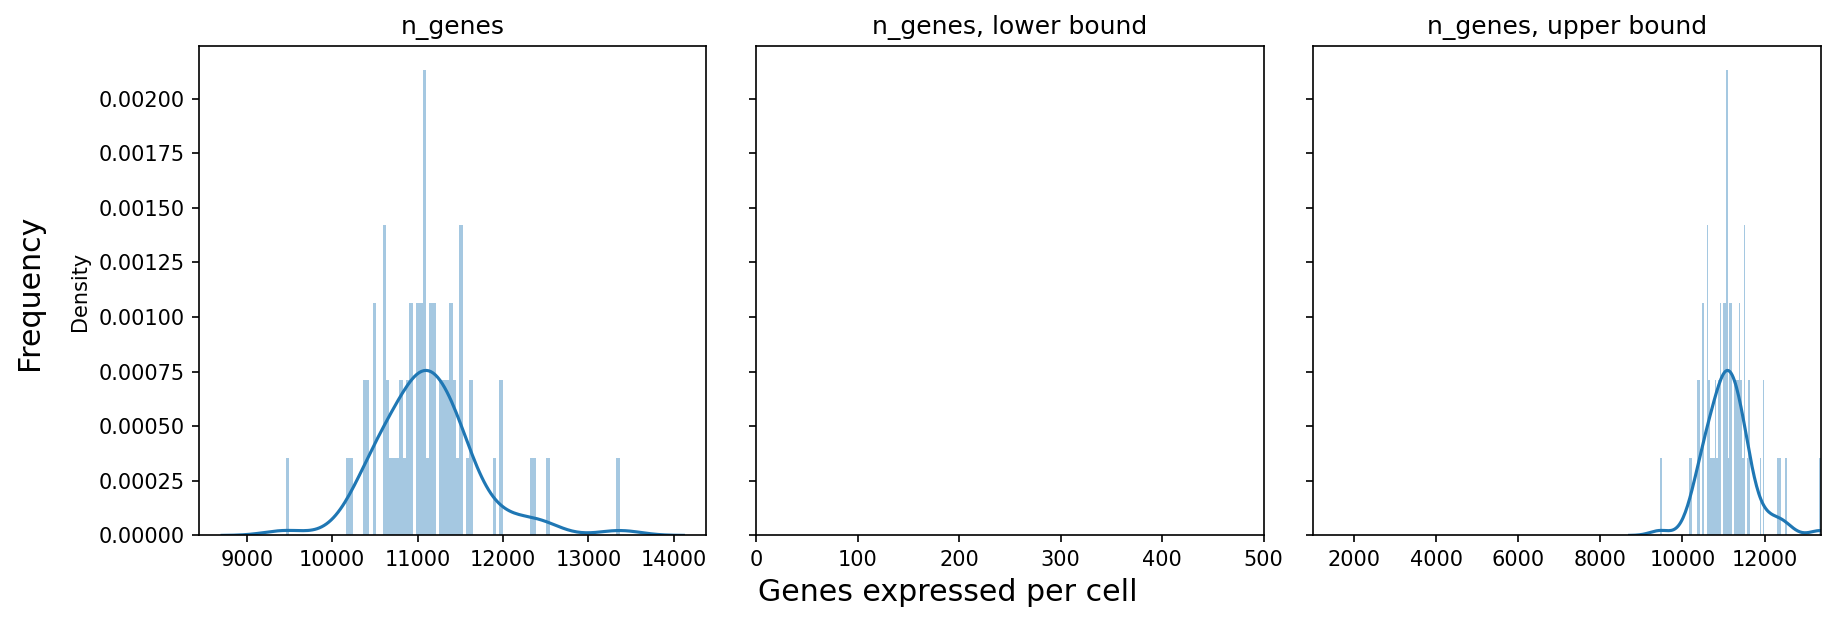

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 500
x_upperbound = 1000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3):
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

In [ ]:
#adata_transpose = adata.T
#sc.tl.tsne(adata_transpose)

In [ ]:
D_RNA.mean().sort_values()

eye-antennal-imaginal-disc_eye-disc-Gal4_x_RNAi-sens           256.250130
wing_imaginal_disc_WT_RAL-208_1-and-2_pooled                   265.178962
eye-antennal-imaginal-disc_Gal4-7_x_slp1                       296.809372
eye-antennal-imaginal-disc_lz-Gal4_x_RNAi-nerfin-1             305.995633
eye-antennal-imaginal-disc_dpp-Gal4_x_RNAi-CG12071             317.415602
                                                                 ...     
eye-antennal-imaginal-disc_ro[1]                              1510.308590
eye-antennal-imaginal-disc_Kr[lf-1]                           1742.687956
eye-antennal-imaginal-disc_hs-Gal4_x_UAS-gl_1-and-2_pooled    1852.856556
eye-antennal-imaginal-disc_FRT-gl[60j]_1-and-2_pooled         2065.592349
eye-antennal-imaginal-disc_gl[60j]_1-and-2_pooled             2593.539690
Length: 72, dtype: float64

In [ ]:
#sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
#sc.pl.tsne(adata, color=['eye-antennal-imaginal-disc_Kr[lf-1]', 'eye-antennal-imaginal-disc_hs-Gal4_x_UAS-gl_1-and-2_pooled', 'eye-antennal-imaginal-disc_FRT-gl[60j]_1-and-2_pooled', 'eye-antennal-imaginal-disc_gl[60j]_1-and-2_pooled' ],
#           title=['Gene expression in eye-antennal-imaginal-disc_Kr[lf-1] ', 'Gene expression in eye-antennal-imaginal-disc_hs-Gal4_x_UAS-gl_1-and-2_pooled', 'Gene expression in eye-antennal-imaginal-disc_FRT-gl[60j]_1-and-2_pooled', 'Gene Expression in eye-antennal-imaginal-disc_gl[60j]_1-and-2_pooled'], ncols=2, use_raw=False)

### Distribution Analysis

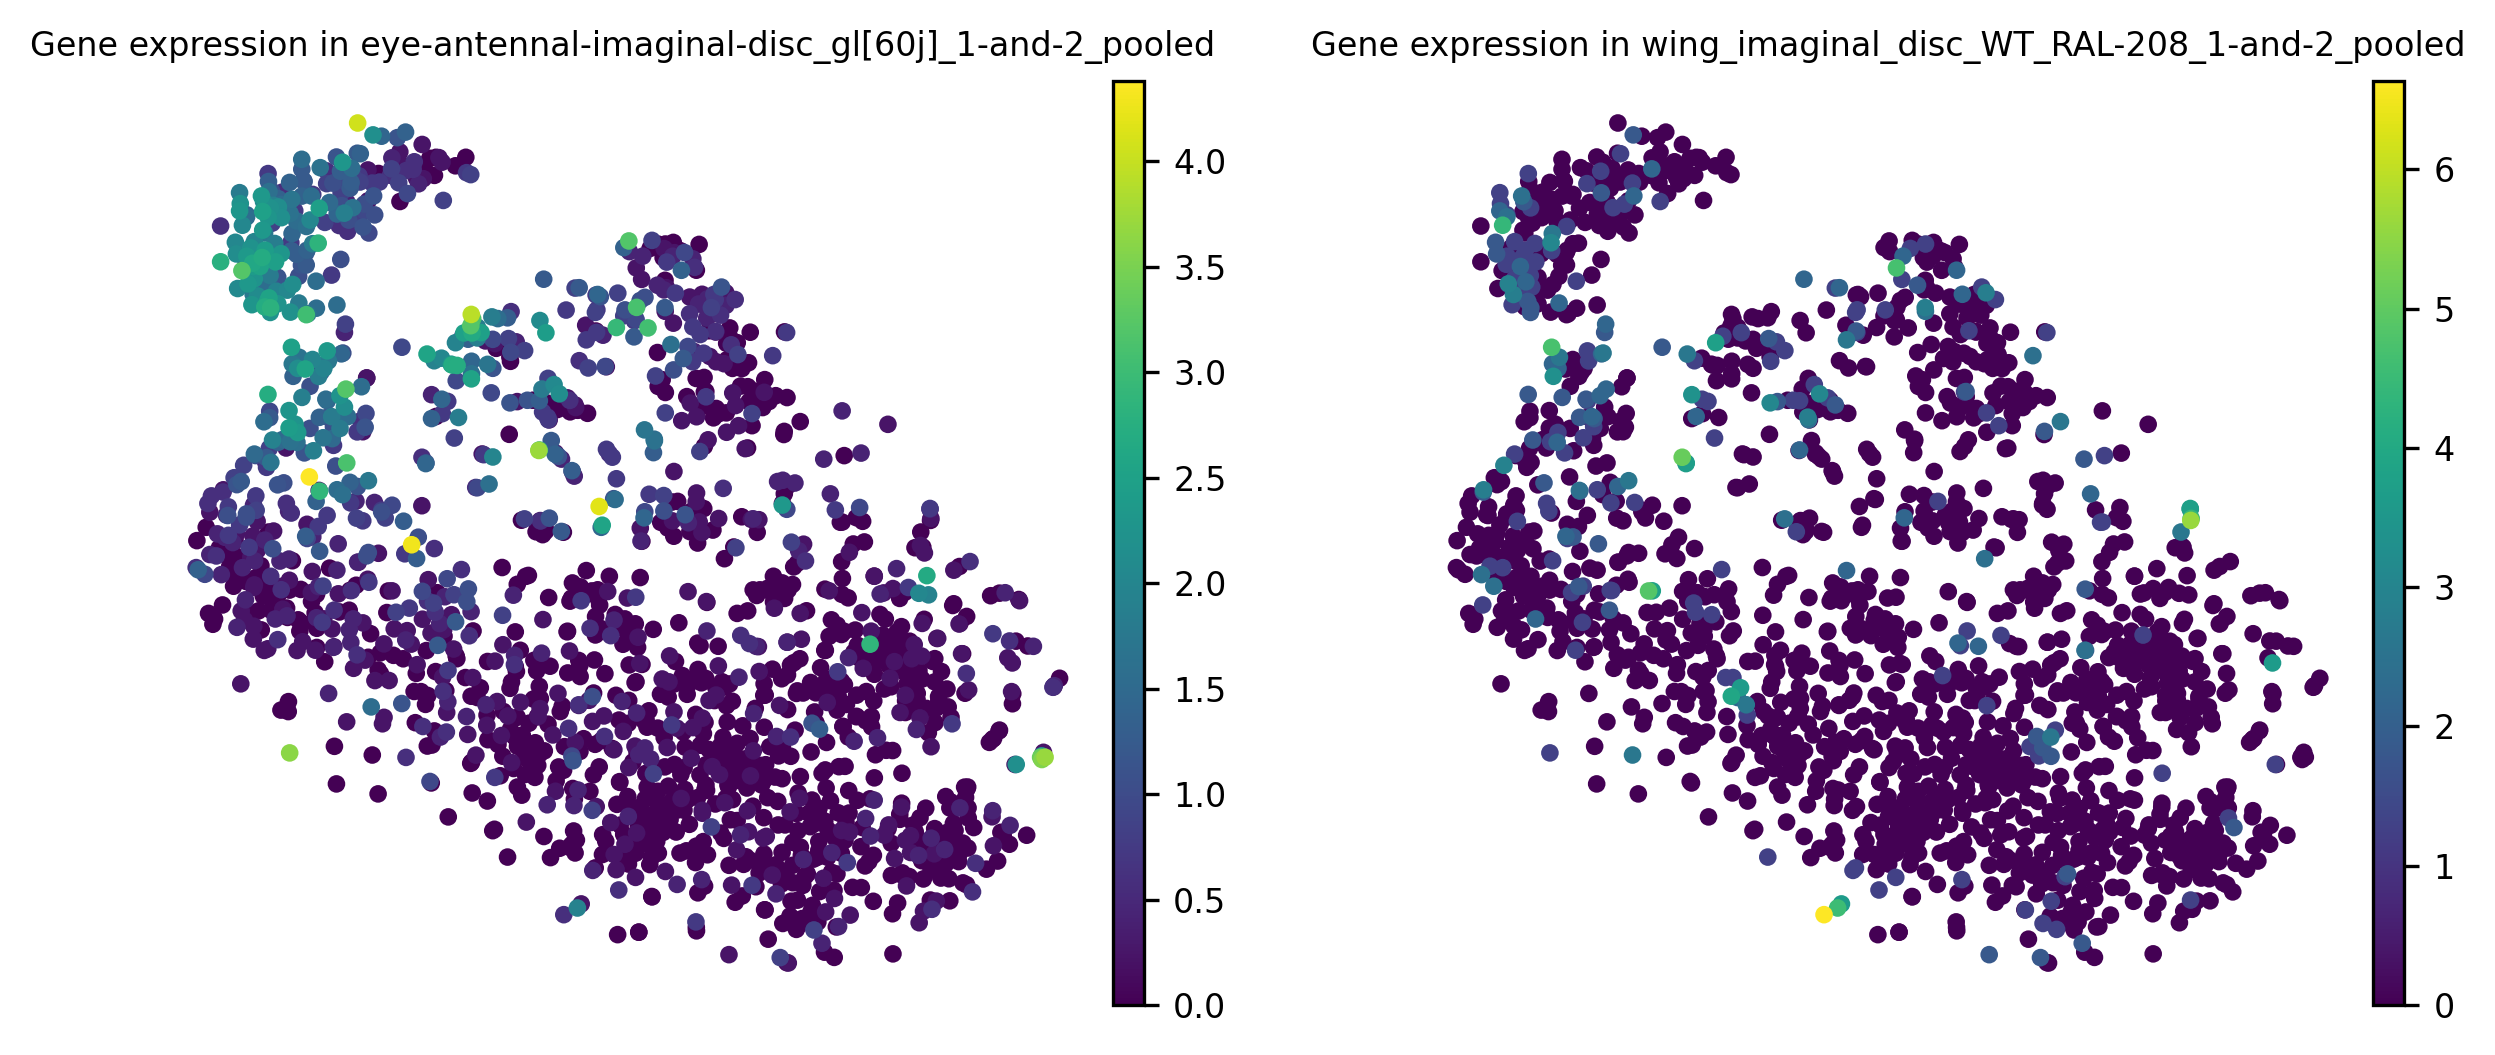

In [ ]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata_transpose, color=['eye-antennal-imaginal-disc_gl[60j]_1-and-2_pooled', 'wing_imaginal_disc_WT_RAL-208_1-and-2_pooled'],
           title=['Gene expression in eye-antennal-imaginal-disc_gl[60j]_1-and-2_pooled ', 'Gene expression in wing_imaginal_disc_WT_RAL-208_1-and-2_pooled'], ncols=2, use_raw=False, vmin=0)

In [ ]:
adata.

AnnData object with n_obs × n_vars = 72 × 1680
    obs: 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

## Preprocessing the GENIE3 Gene expression rankings

- The dataset is an output already produced by a GENIE3 model training

In [ ]:
genie3_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Final_Datasets/GENIE3_Ranking_TF_TG.csv')

In [ ]:
genie3_df.head()

,Unnamed: 0,Unnamed: 1,rank,score,TF,TG
0,dmrt93B,CG14932,1.0,0.854713,dmrt93B,CG14932
1,dmrt93B,Gr63a,2.0,0.843259,dmrt93B,Gr63a
2,dmrt93B,CG14955,3.0,0.836367,dmrt93B,CG14955
3,dmrt93B,Hsp70Aa,4.0,0.834249,dmrt93B,Hsp70Aa
4,dmrt93B,Hsp70Bc,5.0,0.830264,dmrt93B,Hsp70Bc


In [ ]:
score_col = genie3_df.pop('score')
genie3_df.insert(4, 'score', round(score_col,5))

In [ ]:
genie3_df

,Unnamed: 0,Unnamed: 1,rank,TF,score,TG
0,dmrt93B,CG14932,1.0,dmrt93B,0.85471,CG14932
1,dmrt93B,Gr63a,2.0,dmrt93B,0.84326,Gr63a
2,dmrt93B,CG14955,3.0,dmrt93B,0.83637,CG14955
3,dmrt93B,Hsp70Aa,4.0,dmrt93B,0.83425,Hsp70Aa
4,dmrt93B,Hsp70Bc,5.0,dmrt93B,0.83026,Hsp70Bc
...,...,...,...,...,...,...
5827975,CrebA,capu,581129.0,CrebA,0.00000,capu
5827976,CrebA,capt,581129.0,CrebA,0.00000,capt
5827977,CrebA,caps,581129.0,CrebA,0.00000,caps
5827978,zfh2,zye,581129.0,zfh2,0.00000,zye


In [ ]:
genie3_df = genie3_df.iloc[:, 3:6]

In [ ]:
genie3_df

,TF,score,TG
0,dmrt93B,0.85471,CG14932
1,dmrt93B,0.84326,Gr63a
2,dmrt93B,0.83637,CG14955
3,dmrt93B,0.83425,Hsp70Aa
4,dmrt93B,0.83026,Hsp70Bc
...,...,...,...
5827975,CrebA,0.00000,capu
5827976,CrebA,0.00000,capt
5827977,CrebA,0.00000,caps
5827978,zfh2,0.00000,zye


In [ ]:
genie3_df_filtered = genie3_df[(genie3_df[['score']]>0.65).all(axis=1)]

In [ ]:
genie3_df_filtered

,TF,score,TG
0,dmrt93B,0.85471,CG14932
1,dmrt93B,0.84326,Gr63a
2,dmrt93B,0.83637,CG14955
3,dmrt93B,0.83425,Hsp70Aa
4,dmrt93B,0.83026,Hsp70Bc
5,GATAe,0.82495,PH4alphaPV
6,fkh,0.82274,MRE23
7,shn,0.81887,CG14471
8,dmrt93B,0.81283,Hsp70Bbb
9,CG13510,0.79432,CG13511


In [ ]:
genie3_df_filtered.to_csv("/content/drive/MyDrive/Colab_Notebooks/Final_Datasets/GRN_ranking_genie3_65_filtered.csv")

## Analysing the Glass Gene

Trying to find out how many target genes are being regulated by the Glass (gl) genes according to the output generated by GENIE3

In [ ]:
genie3_df_gl = genie3_df.loc[genie3_df['TF'] == 'gl']

In [ ]:
genie3_df_gl.head()

,TF,score,TG
475,gl,0.40481,so
669,gl,0.36903,Cad88C
745,gl,0.35735,CG34245
943,gl,0.32956,CG5921
1994,gl,0.25638,CG34342


In [ ]:
genie3_df_gl = genie3_df_gl[(genie3_df_gl[['score']]>0.05).all(axis=1)]
genie3_df_gl.shape

(101, 3)

## Generating GRNBoost2 rankings

In [ ]:
!pip install arboreto

In [ ]:
from arboreto.algo import grnboost2, genie3
from arboreto.utils import load_tf_names

In [ ]:
X = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/PotieretAl/GSE59059_all_network_experiments.countstable.txt",sep="\t")
# drop the genes that have no symbol (only 4)
c = Counter(X.Symbol)
{ k: c[k] for k in c if c[k]>1}
X = X.dropna()
# Set the index
X.index = X["Symbol"]
# Delete non-count columns
del X["ID"]
del X["Symbol"]
X.describe()

,Larval_brain_WT_RAL-208,Larval_brain_WT_cs,wing_imaginal_disc_WT_RAL-208_1-and-2_pooled,wing_imaginal_disc_WT_cs,eye-antennal_disc_RAL-80_GSM978988,eye-antennal_disc_cs_GSM978987,eye-antennal-imaginal-disc_GMR27H09-Gal4,eye-antennal-imaginal-disc_GMR-Gal4,eye-antennal-imaginal-disc_ato-Gal4,eye-antennal-imaginal-disc_sens-Gal4_x_UAS-GFP,...,eye-antennal-imaginal-disc_hs-Gal4_x_UAS-dfd,eye-antennal-imaginal-disc_ato-Gal4_x_UAS-repo,eye-antennal-imaginal-disc_ato-Gal4_x_EP-dip3,eye-antennal-imaginal-disc_GMR-gal4_x_UAS-Lim3,eye-antennal-imaginal-disc_m4-Gal4_x_UAS-mam,eye-antennal-imaginal-disc_m4-Gal4_x_EP-danr,eye-antennal-imaginal-disc_ato-Gal4_x_EP-dan,eye-antennal-imaginal-disc_m4-Gal4_x_EP-gbsN,eye-antennal-imaginal-disc_GMR-Gal4_x_UAS-lab,eye-antennal-imaginal-disc_GMR-Gal4_x_UAS-Su(H)
count,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,...,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000,15344.000000
mean,1311.319278,850.904523,265.178962,879.284606,782.075078,799.155370,886.443040,619.000261,767.474518,831.387122,...,1048.688282,650.349778,488.166254,499.890967,1021.687891,1140.607273,909.077294,893.204249,632.906999,560.539820
std,4482.976669,2986.855684,1216.288561,3570.659145,2946.427448,3074.458065,3420.261827,2308.404611,2855.369908,3241.210766,...,4346.937659,2454.062467,1991.275518,1870.338031,3866.536707,4580.551307,3448.262659,3423.441766,3045.236034,2047.680413
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,135.000000,79.000000,6.000000,34.500000,65.000000,61.500000,58.000000,45.000000,40.000000,88.000000,...,42.000000,47.000000,15.000000,18.000000,45.000000,43.000000,33.000000,39.000000,36.000000,35.000000
75%,1019.000000,690.250000,178.000000,632.000000,582.000000,604.000000,660.000000,462.000000,571.000000,669.250000,...,777.250000,489.000000,367.000000,369.000000,763.000000,872.000000,667.000000,691.250000,451.000000,425.000000
max,181839.000000,121099.000000,61978.000000,193009.000000,164390.000000,163272.000000,169778.000000,122793.000000,142564.000000,177544.000000,...,254332.000000,130429.000000,97107.000000,102794.000000,210277.000000,253123.000000,181913.000000,177931.000000,187969.000000,102569.000000


In [ ]:
X_n = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/PotieretAl/GSE59059_all_network_experiments.vst.txt",sep="\t")
X_n = X_n.dropna() # drop the genes that have no symbol (only 4)
X_n.index = X_n["Symbol"]
del X_n["ID"]
del X_n["Symbol"]
X_n.head()

,Larval_brain_WT_RAL-208,Larval_brain_WT_cs,wing_imaginal_disc_WT_RAL-208_1-and-2_pooled,wing_imaginal_disc_WT_cs,eye-antennal_disc_RAL-80_GSM978988,eye-antennal_disc_cs_GSM978987,eye-antennal-imaginal-disc_GMR27H09-Gal4,eye-antennal-imaginal-disc_GMR-Gal4,eye-antennal-imaginal-disc_ato-Gal4,eye-antennal-imaginal-disc_sens-Gal4_x_UAS-GFP,...,eye-antennal-imaginal-disc_hs-Gal4_x_UAS-dfd,eye-antennal-imaginal-disc_ato-Gal4_x_UAS-repo,eye-antennal-imaginal-disc_ato-Gal4_x_EP-dip3,eye-antennal-imaginal-disc_GMR-gal4_x_UAS-Lim3,eye-antennal-imaginal-disc_m4-Gal4_x_UAS-mam,eye-antennal-imaginal-disc_m4-Gal4_x_EP-danr,eye-antennal-imaginal-disc_ato-Gal4_x_EP-dan,eye-antennal-imaginal-disc_m4-Gal4_x_EP-gbsN,eye-antennal-imaginal-disc_GMR-Gal4_x_UAS-lab,eye-antennal-imaginal-disc_GMR-Gal4_x_UAS-Su(H)
Symbol,,,,,,,,,,,,,,,,,,,,,
a,0.097588,-0.573724,-0.056409,-0.234239,1.176561,1.118648,1.417965,1.453385,1.265963,0.923819,...,1.813833,1.111934,1.343877,1.558966,1.541655,1.182701,1.458329,1.293854,1.328125,1.096165
abd-A,-0.540559,-0.267757,-4.128741,-3.741868,-1.797394,-1.810764,-3.853757,-3.761000,-4.762305,-2.180905,...,-4.069033,-0.969187,-4.408945,-4.426116,-4.139570,-4.572236,-4.383997,-4.804387,-4.020351,-4.089043
Abd-B,-2.162271,-1.900965,-4.424084,-4.272092,-3.209699,-3.030914,-4.617151,-4.133704,-4.762305,-3.242686,...,-4.258546,-2.431856,-4.640305,-4.262626,-4.828815,-4.691054,-4.801042,-4.625695,-4.703549,-4.089043
Abl,2.711761,2.611861,1.594489,1.326987,2.069639,2.241971,2.343236,2.477474,2.364067,1.945038,...,2.091304,2.353409,2.110572,2.551806,2.394968,1.905280,2.504342,1.854220,2.154057,1.958742
abo,-1.336773,-1.835230,-0.903334,-1.242570,-1.101404,-1.499770,-1.203447,-1.297828,-1.311337,-1.421405,...,-0.847642,-1.413433,-1.384939,-1.241106,-1.280231,-1.073723,-1.210374,-1.036822,-1.293409,-1.129657


In [ ]:
TF = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/PotieretAl/Drosophila_melanogaster_TF.txt",header=0 , sep = '\t',
                 names=['Species', 'Symbol','Ensembl','Family','Protein', 'Entrez_ID'])

In [ ]:
TF_genes = TF['Symbol'].values

In [ ]:
TF_genes = list(TF_genes)

In [ ]:
epsilon = 1
logTPM = np.log10(X+epsilon)

X_ = logTPM[logTPM.max(axis=1)>1.5]
X_.shape

(10635, 72)

In [ ]:
X_transpose = X_.T
X_transpose= X_transpose.loc[:, (X_transpose != 0).any(axis=0)]
X_transpose.iloc[:,:].head()

Symbol,a,abd-A,Abd-B,Abl,abo,ac,Ace,acj6,Acph-1,nAcRalpha-96Aa,...,CR43889,CG43894,CG43896,CG43897,Eip93F,how,CkIIalpha,rdx,CG17646,gpp
Larval_brain_WT_RAL-208,3.060698,2.838849,2.201397,3.897352,2.542825,2.071882,3.792952,2.720159,2.856124,2.986324,...,1.041393,0.00000,4.340206,2.606381,3.624798,3.334051,3.750045,3.574031,2.683947,3.905850
Larval_brain_WT_cs,2.649335,2.757396,2.136721,3.688865,2.164353,1.740363,3.661434,2.481443,2.698101,2.731589,...,0.477121,0.30103,3.104146,1.968483,3.443732,3.123852,3.625621,3.324899,2.659916,3.511081
wing_imaginal_disc_WT_RAL-208_1-and-2_pooled,2.283301,0.301030,0.000000,2.824126,1.982271,2.000000,1.041393,0.698970,2.143015,0.301030,...,0.000000,0.00000,1.146128,1.568202,0.602060,3.038620,3.124504,2.750508,1.397940,3.093422
wing_imaginal_disc_WT_cs,2.756636,1.146128,0.698970,3.273927,2.389166,2.418301,2.008600,1.255273,2.721811,0.778151,...,0.000000,0.69897,3.959947,2.209515,1.995635,3.485295,3.618048,3.242044,1.732394,3.544192
eye-antennal_disc_RAL-80_GSM978988,3.201124,2.143015,1.462398,3.483445,2.418301,2.397940,3.045323,1.832509,2.750508,2.012837,...,0.301030,0.00000,1.176091,2.294466,2.768638,3.337858,3.560624,3.517855,2.164353,3.583765


In [ ]:
tflist_present = set(X_transpose.columns).intersection(TF_genes)
targetlist_present = list(set(X_transpose.columns).intersection(TF_genes))
targetlist_present = targetlist_present.sort()

In [ ]:
X_transpose.to_csv('/content/drive/MyDrive/Colab_Notebooks/Final_Datasets/Drosophila_RNAseq_T.tsv', sep='\t')

In [ ]:
network = grnboost2(expression_data=X_transpose,
                    tf_names=TF_genes)

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:38701
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42787'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44771'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:40987', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40987
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:43450
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:44065', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44065
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:43458
INFO:distributed.scheduler:Receive client connection: Client-a3eedcb1-eb7a-11ee-81bb-0242ac1c000c

In [ ]:
network.head(50)

In [ ]:
len(network)

4879738

In [ ]:
network.to_csv('/content/drive/MyDrive/Colab_Notebooks/Final_Datasets/GRNBoost2_network.tsv', sep='\t', header=False, index=False)

Text(0.5, 0, 'score')

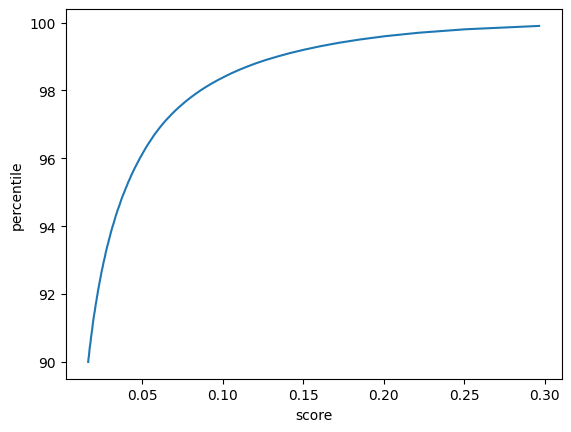

In [ ]:
perc = np.arange(90,100,0.1)
plt.plot(np.percentile(round(network["importance"]/100,4),perc),perc,"-")
plt.ylabel("percentile")
plt.xlabel("score")

In [ ]:
GRNBoost2_filtered =  network[(network[['importance']]>50.0).all(axis=1)]

In [ ]:
GRNBoost2_filtered

,TF,target,importance
430,TFAM,exo70,83.328797
374,Tsf2,CG9634,67.175951
474,Atf-2,CG32815,66.300041
46,her,CG8613,64.705387
531,cnc,CG15099,61.243711
...,...,...,...
268,CG2116,CG3887,50.177971
401,CG8478,barr,50.175788
192,Dref,CG6707,50.112849
210,Xbp1,CG5382,50.108733


In [ ]:
score_col = GRNBoost2_filtered.pop('importance')
GRNBoost2_filtered.insert(1, 'importance', round(score_col/100,5))

In [ ]:
GRNBoost2_filtered

,TF,importance,target
430,TFAM,0.83329,exo70
374,Tsf2,0.67176,CG9634
474,Atf-2,0.66300,CG32815
46,her,0.64705,CG8613
531,cnc,0.61244,CG15099
...,...,...,...
268,CG2116,0.50178,CG3887
401,CG8478,0.50176,barr
192,Dref,0.50113,CG6707
210,Xbp1,0.50109,CG5382


In [ ]:
GRNBoost2_filtered.to_csv('/content/drive/MyDrive/Colab_Notebooks/Final_Datasets/GRNBoost2_filtered_50.tsv', sep='\t', header=False, index=False)

## Analysis of GENIE3 and GRNBoost2 Networks

In [ ]:
## Loading both datasets:
#GRNBoost2_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Final_Datasets/GRNBoost2_network.tsv', sep='\t', names=['TF', 'Target', 'Score'], header = None)
#genie3_df    = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Final_Datasets/GENIE3_Ranking_TF_TG.csv', sep='\t', names=['TF', 'Score', 'Target'], header = None)

In [ ]:
GRNBoost2_df.head()

,TF,Target,Score
0,TFAM,exo70,83.328797
1,Tsf2,CG9634,67.175951
2,Atf-2,CG32815,66.300041
3,her,CG8613,64.705387
4,cnc,CG15099,61.243711


In [ ]:
print('GRNBoost2 Network no. of links:' , len(GRNBoost2_df))
print('Genie3    Network no. of links:' , len(genie3_df))

GRNBoost2 Network no. of links: 4879738
Genie3    Network no. of links: 5827981
